In [1]:
#Ｉmport necessary packages
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import xitorch
from xitorch.optimize import rootfinder
import optuna
from torch.utils.data import TensorDataset, DataLoader
import joblib 
import torch.optim as optim

# Memory management on GPU
import gc

# Import time
import time

# Testify whether GPU is available
print("Cuda is available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Device is: ", device)

def memory_stats():
    print("Memory allocated: ", torch.cuda.memory_allocated()/1024**2)
    print("Memory cached: ", torch.cuda.memory_reserved()/1024**2)
memory_stats()

/home/shengduo/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cuda is available:  True
Device is:  cuda:0
Memory allocated:  0.0
Memory cached:  0.0


In [30]:
# Generate / load data
# dataPrefix = "Trial1108_bigDRS_Burigede"
dataPrefix = "Trial1116_smallDRS_largeA"
dataFile = "./data/" + dataPrefix + ".pt"

shit = torch.load(dataFile)
Vs = shit["Vs"]
thetas = shit["thetas"]
fs = shit["fs"]
ts = shit["ts"]

# Now Vs and ts have fixed length
print("Vs.shape: ", Vs.shape)
print("thetas.shape: ", thetas.shape)
print("fs.shape: ", fs.shape)
print("ts.shape: ", ts.shape)
# Calculate Xs
Xs = torch.zeros(Vs.shape)
Xs[:, 1:] = torch.cumulative_trapezoid(Xs, ts)
print("Xs.shape: ", Xs.shape)

# Load dataset 
# Initialize dataloaders
AllData = TensorDataset(
    Xs, 
    Vs, 
    ts, 
    fs
)

dataloader_kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)

train_len = int(len(Vs) * 0.8)
test_len = len(Vs) - train_len
# trainDataset, testDataset = torch.utils.data.random_split(AllData, [train_len, test_len])
# Created using indices from 0 to train_size.
trainDataset = torch.utils.data.Subset(AllData, range(train_len))

# Created using indices from train_size to train_size + test_size.
testDataset = torch.utils.data.Subset(AllData, range(train_len, train_len + test_len))

# Set testing data loader
testing_batch_size = len(testDataset) # 256
testDataLoader = DataLoader(
    testDataset,
    batch_size = testing_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    **dataloader_kwargs, 
)

Vs.shape:  torch.Size([100, 100])
thetas.shape:  torch.Size([100, 100])
fs.shape:  torch.Size([100, 100])
ts.shape:  torch.Size([100, 100])
Xs.shape:  torch.Size([100, 100])


# Visualize Results with D_dagger, D and W

In [31]:
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare
dim_xis = [0, 1, 2, 4, 8]

models = []
for idx, dim_xi in enumerate(dim_xis):
    # model_correction = torch.load('./model/Trial1116_bigDRS_Burigede_dim_xi_{0}_model.pth'.format(dim_xi))
    # model_correction = torch.load('./model/Trial1116_smallDRS_dim_xi_{0}_model.pth'.format(dim_xi))
    # model_correction = torch.load('./model/Trial1116_smallDRS_withOffSet_dim_xi_{0}_model.pth'.format(dim_xi))
    model_this = torch.load("./model/" + dataPrefix + "_dimXi_" + str(dim_xi) + ".pth")
    models.append(model_this)
    res_corr = train1Epoch(testDataLoader, Loss, model_this, 2, update_weights=False)
    print("Test loss with xi = {0}: ".format(dim_xi), res_corr)

# Load models one by one
this_Xs = torch.stack([testDataset[i][0] for i in range(len(testDataset))], dim=0)
this_Vs = torch.stack([testDataset[i][1] for i in range(len(testDataset))], dim=0)
this_ts = torch.stack([testDataset[i][2] for i in range(len(testDataset))], dim=0)
this_fs = torch.stack([testDataset[i][3] for i in range(len(testDataset))], dim=0)
this_Xs = this_Xs.to(device)
this_Vs = this_Vs.to(device)
this_ts = this_ts.to(device)
this_fs = this_fs.to(device)

this_f_preds = []
for model_this in models:
    model_this.calf(this_Xs, this_Vs, this_ts)
    this_f_pred = model_this.fs.to("cpu").detach()
    this_f_preds.append(this_f_pred)

this_Xs = this_Xs.to("cpu")
this_Vs = this_Vs.to("cpu")
this_ts = this_ts.to("cpu")
this_fs = this_fs.to("cpu")

Test loss with xi = 0:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)
Test loss with xi = 1:  tensor(0.1151, device='cuda:0', grad_fn=<DivBackward0>)
Test loss with xi = 2:  tensor(0.1150, device='cuda:0', grad_fn=<DivBackward0>)
Test loss with xi = 4:  tensor(0.1152, device='cuda:0', grad_fn=<DivBackward0>)
Test loss with xi = 8:  tensor(1., device='cuda:0', grad_fn=<DivBackward0>)


[Text(0.5, 0, 'Time [s]'), Text(0, 0.5, 'Friction')]

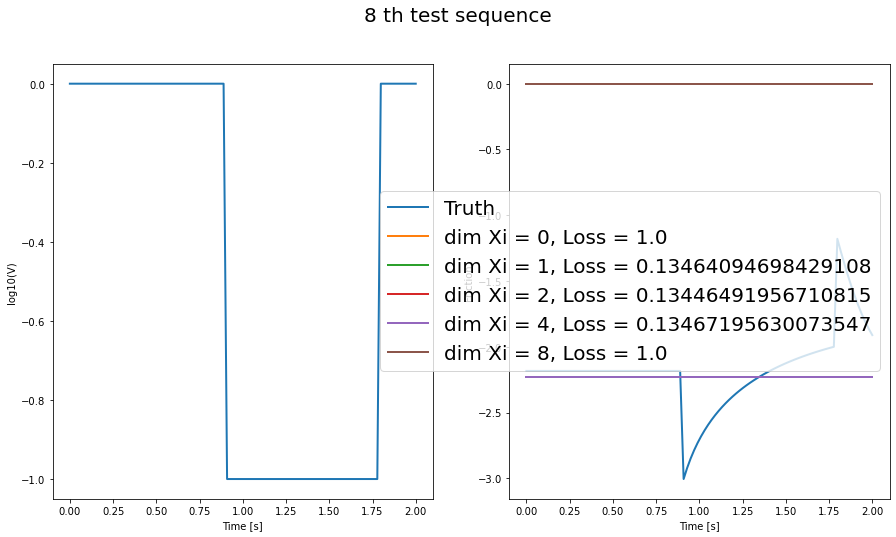

In [36]:
# Plot a fitted sequence
def cal_Loss(f, f_targ, t, p=2):
    return torch.pow(
        torch.trapezoid(torch.pow(torch.abs(f - f_targ), p), t) / torch.trapezoid(torch.pow(torch.abs(f_targ), p), t), 
        1./ p
    )

idx = torch.randint(len(testDataset), (1, ))[0]
# idx = 19
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle("{0} th test sequence".format(idx), fontsize=20)

axs[0].plot(this_ts[idx, :], torch.log10(this_Vs[idx, :]), linewidth=2.0)
axs[0].set(xlabel = "Time [s]", ylabel = "log10(V)")

axs[1].plot(this_ts[idx, :], this_fs[idx, :], linewidth=2.0, label='Truth')

for dim_xi, this_f_preds_withCorrection in zip(dim_xis, this_f_preds):
    this_loss = cal_Loss(this_f_preds_withCorrection[idx, :], this_fs[idx, :], this_ts[idx, :])
    axs[1].plot(this_ts[idx, :], this_f_preds_withCorrection[idx, :], linewidth=2.0, label='dim Xi = {0}, Loss = {1}'.format(dim_xi, this_loss))
axs[1].legend(fontsize=20)
# axs[1].set_ylim(0., 0.8)
axs[1].set(xlabel = "Time [s]", ylabel = "Friction")

In [8]:
dim_xis = [0, 1, 2]
for idx, dim_xi in enumerate(dim_xis):
    print("-" * 20, " dim_xi = ", dim_xi, " ", "-" * 20)
    # shit = joblib.load('./data/1104study_dim_xi_logV_DLeg_ELU1_{0}.pkl'.format(dim_xi))
    # shit = joblib.load('./data/1104_WDsep_study_dim_xi_logV_DLeg_D_dagger_ELU1_{0}.pkl'.format(dim_xi))
    # shit = joblib.load('./data/1106_smallDRS_WDsep_study_dim_xi_logV_DLeg_D_dagger_ELU1_{0}.pkl'.format(dim_xi))
    # shit = joblib.load('./data/1108_bigDRS_WDsep_study_dim_xi_logV_DLeg_D_dagger_ELU1_{0}.pkl'.format(dim_xi))
    # shit = joblib.load('./data/1108_bigDRS_Burigede_WDsep_study_dim_xi_logV_DLeg_D_dagger_ELU1_{0}.pkl'.format(dim_xi))
    shit = joblib.load('./data/Stupid_1116_bigDRS_Burigede_WDsep_study_dim_xi_logV_DLeg_D_dagger_ELU1_{0}.pkl'.format(dim_xi))
    print("best_params: ", shit.best_params)
    print("best_value: ", shit.best_value)

--------------------  dim_xi =  0   --------------------
best_params:  {'W_layers': 6, 'W_layer_units_exponent_0': 9, 'W_layer_units_exponent_1': 8, 'W_layer_units_exponent_2': 4, 'W_layer_units_exponent_3': 4, 'W_layer_units_exponent_4': 8, 'W_layer_units_exponent_5': 9, 'D_layers': 7, 'D_layer_units_exponent_0': 8, 'D_layer_units_exponent_1': 7, 'D_layer_units_exponent_2': 10, 'D_layer_units_exponent_3': 6, 'D_layer_units_exponent_4': 4, 'D_layer_units_exponent_5': 8, 'D_layer_units_exponent_6': 6, 'D_dagger_layers': 7, 'D_dagger_layer_units_exponent_0': 4, 'D_dagger_layer_units_exponent_1': 10, 'D_dagger_layer_units_exponent_2': 10, 'D_dagger_layer_units_exponent_3': 8, 'D_dagger_layer_units_exponent_4': 10, 'D_dagger_layer_units_exponent_5': 4, 'D_dagger_layer_units_exponent_6': 6, 'log_learning_rate': -1.3076749726724581, 'log_learning_rate_D': -1.2873674609771453, 'log_learning_rate_D_dagger': -3.6977633460284145, 'training_batch_size': 10, 'training_p': 2}
best_value:  0.0665002